<a href="https://colab.research.google.com/github/bdrinconp/ml_mnist/blob/main/notebooks/NaiveBayes_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador y generador de dígitos utilizando naive bayes

## 1. Carga, preparación y selección del conjunto de datos

In [19]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

A continuación se realiza la carga del conjunto de datos de MNIST.

In [2]:
digits = datasets.fetch_openml('mnist_784', version=1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Luego, se extraen las imágenes y sus correspondientes etiquetas. Es importante tener en cuenta que las imágenes están representadas a través de un dataframe, donde cada fila corresponde a una imagen y cada columna con los píxeles asociados.

En este caso, cada imagen es de 28x28 píxeles, por lo que se cuenta con 784 columnas y 70,000 imágenes. Por otro lado, las etiquetas asociadas a las imágenes corresponden con los números 0,1,2,3,4,5,6,7,8 y 9.

Otro aspecto importante a considerar es el siguiente: Los valores de los píxeles en el conjunto de datos MNIST no son binarios, sino que son valores en escala de grises, los cuales representan la intensidad de cada píxel. Los valores de los píxeles en las imágenes del conjunto de datos son números enteros entre 0 y 255, donde:

* 0 representa el color negro (es decir, la ausencia de intensidad o color en el píxel).

* 255 representa el color blanco (es decir, la máxima intensidad o color en el píxel).

* Los valores entre 0 y 255 representan diferentes tonos de gris, donde valores más cercanos a 0 son más oscuros, y valores más cercanos a 255 son más claros.

In [3]:
images = digits.data
labels = digits.target

In [4]:
images.head().to_csv('file_name.csv', index=False)

In [5]:
images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
labels.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Realizando una pequeña exploración podemos verificar como se ven las imagenes.

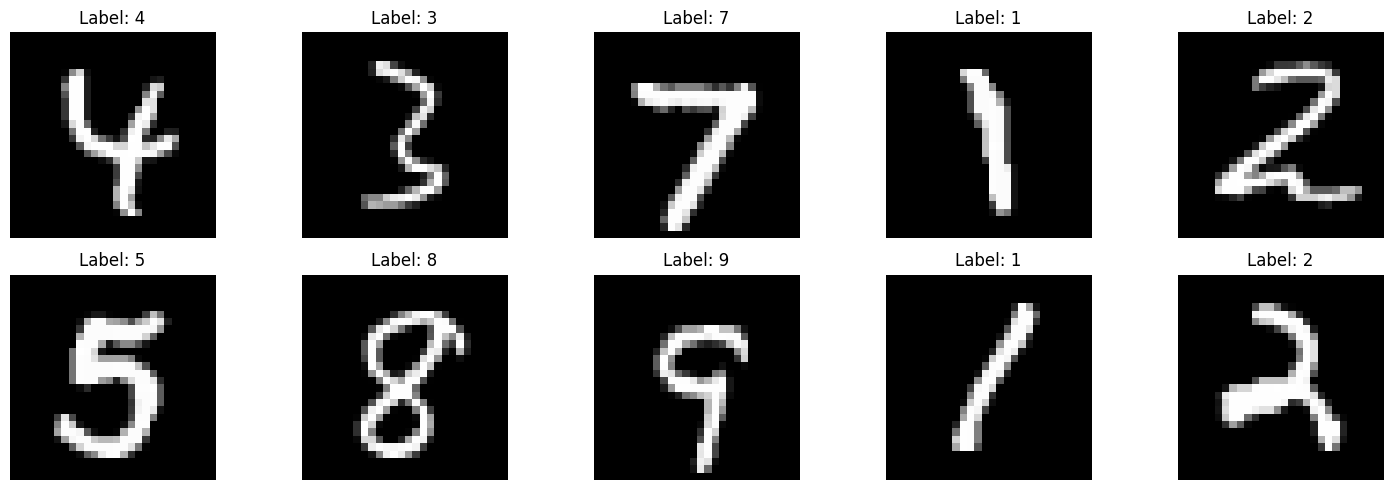

In [7]:
random_indices = random.sample(range(len(images)), 10)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images.iloc[idx].values.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 1.1 Normalización del conjunto de datos

En este caso, dado que se trabaja con escala de grises, es necesario normalizar los datos para que los dígitos se encuentren en el rango entre 0 y 1. Para lograr esto, dividiremos cada dato entre 255.

In [8]:
images_normalized = images/255

### 1.3 Selección del conjunto de datos

Se realiza la selección de un conjunto de datos tamaño n, a partir del cual se realiza la construccipon de los conjunto de entrenamiento (train) y de prueba (test).

Tanto la selección del conjunto de datos y la construcción de los conjuntos de train y test se realiza de forma balanceada, haciendo uso del parametro stratify a partir de los labels.

In [9]:
n = 10000  # tamaño del conjunto de datos a trabajar.
seed = 42
_, X, _, y = train_test_split(images_normalized, labels, test_size=n, stratify=labels, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

## 2. Construcción del modelo Naive Bayes


$$ P(C_k|\textbf{x}) = \frac{P(\textbf{x}|C_k)P(C_k)}{P(\textbf{x})}$$

Donde $C_k$ corresponde con el número de clases posibles para el conjunto de datos, en nuestro caso 10 clases (k = 0,1,2,...,9) y $\textbf{x}$ el vector de pixeles.

Es importante tener en cuenta que la probabilidad $P(\textbf{x})$ se puede considerar un factor de normalización, luego se suficiente con identificar el valor $C_k$ que maximiza $P(C_k|\textbf{x})$. Es decir:

$$C = arg \ max_k P(\textbf{x}|C_k)P(C_K)  $$

En primer lugar calculamos las distribuciones a priori $P(C_k)$, las cuales corresponden con la probabilidad asociada a cada digito en el conjunto de datos de entrenamiento.

In [10]:
label_counts = y_train.value_counts()

total_examples = len(y_train)
prior_probabilities = label_counts / total_examples

prior_df = pd.DataFrame(prior_probabilities).reset_index()
prior_df.columns = ['Label', 'Prior Probability']

prior_df

,Label,Prior Probability
0,1,0.112500
1,7,0.104250
2,3,0.102000
3,2,0.099875
4,9,0.099375
5,0,0.098625
6,6,0.098125
7,4,0.097500
8,8,0.097500
9,5,0.090250


Ahora, se realiza el calculo de la probabilidades condicionales $P(\textbf{x}|C_k)$.

In [11]:
def pixel_prop(df_normalized, labels, umbral):

    pixel_proportions = {label: np.zeros((28, 28)) for label in np.unique(labels)}

    for label in np.unique(labels):
        images_label = df_normalized[labels == label].values
        pixel_proportions[label] = np.mean(images_label > umbral, axis=0)

    proportions_df = pd.DataFrame.from_dict(pixel_proportions, orient='index')

    return proportions_df

In [40]:
umbral = 0.25
proportions_x_ck_df = pixel_prop(df_normalized = X_train, labels = y_train, umbral = umbral)

proportions_x_ck_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009592,0.004796,0.002398,0.001199,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.001258,0.001258,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Hasta este punto se ha realizado el calculo de la probabilidades $P(C_k)$ y $P(\textbf{x}|C_k)$, haciendo uso del conjunto de entrenamiento.

## 3. Implementación del modelo y desempeño del modelo

Con el objetivo de ilustrar la implementación se presenta el siguiente ejemplo:

1. Supongamos que tenemos tres píxeles $[0.8, 0, 0.5]$, entonces dado que la etiqueta es $C_k$:

* La probabilidad de que el primer píxel esté encendido es 0.8.

* La probabilidad de que el segundo píxel este encendido es 0.

* La probabilidad de que el tercer píxel esté encendido es 0.5.

Ahora, se realiza el calculo de la veosimilitud:


$$ likelihood = [0.8, 0, 0.5] * [1, 0, 1] + ([1,1,1]- [0.8, 0, 0.5]) * ([1,1,1] - [1, 0, 1])$$


$$ likelihood = [0.8, 0, 0.5] * [1, 0, 1] + [0.2,1,0.5]*[0,1,0]$$

$$likelihood = [0.8*1, 0*0, 0.5*1] + [0.2*0, 1*1, 0.5*0]$$

$$likelihood = [0.8, 0, 0.5] + [0, 1, 0]$$


Luego el vector likelihood es:

$$likelihood = [0.8, 1, 0.5]$$

Cada compoenente del vector likelihood representa la probabilidad de observar el estado del píxel correspondiente (encendido o apagado) dado que la imagen pertenece a $C_k$.

2. Una vez calculado el vector de likelihood, calculamos:

$$total \ likelihood  = \prod likelihood_i$$

3. Luego, este likelihood total se multiplica por la probabilidad a priori de la clase $P(C_k)$ para obtener el probabilidad a posteriori de la clase dada la imagen.

$$ posterior = total \ likelihood * P(C_k)$$

4. Finalmente, se compara la probabilidad a posteriori calculada para cada clase, y se elige la clase con la mayor probabilidad a posteriori como la predicción para la imagen.

$$C = arg \ max_k posterior_k $$


In [41]:
X_val_binarized = X_val > umbral

predictions = []

for index, image in X_val_binarized.iterrows():
    posteriors = {}

    for label in np.unique(labels):  # Iterar sobre cada clase C_k
        likelihood = proportions_x_ck_df.loc[label].values * image + (1 - proportions_x_ck_df.loc[label].values) * (1 - image)  # Calcular P(x | C_k)
        posterior = np.prod(likelihood) * prior_probabilities[label]  # Calcular P(C_k | x)
        posteriors[label] = posterior

    predicted_label = max(posteriors, key=posteriors.get)  # Seleccionar la clase con la mayor probabilidad posterior
    predictions.append(predicted_label)

### 3.1 Evaluación del modelo

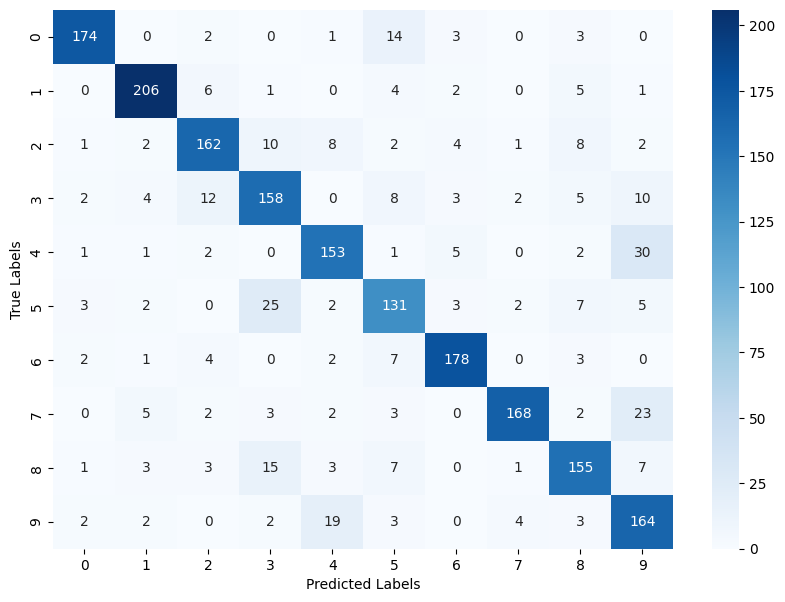

In [15]:
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [16]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       197
           1       0.91      0.92      0.91       225
           2       0.84      0.81      0.82       200
           3       0.74      0.77      0.76       204
           4       0.81      0.78      0.79       195
           5       0.73      0.73      0.73       180
           6       0.90      0.90      0.90       197
           7       0.94      0.81      0.87       208
           8       0.80      0.79      0.80       195
           9       0.68      0.82      0.74       199

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.83      2000



### 3.2 Validación cruzada para elección del umbral

In [23]:
k_folds = 5
umbrales = np.linspace(0, 1, 5)
kf = KFold(n_splits=k_folds)

resultados = {}

for umbral in umbrales:
    accuracies = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Binarizar los datos
        X_train_binarized = X_train_fold > umbral
        X_val_binarized = X_val_fold > umbral

        # P(C_k)
        label_counts = y_train_fold.value_counts()  # Actualizado para usar el fold actual
        total_examples = len(X_train_fold)  # Actualizado para usar el fold actual
        prior_probabilities = label_counts / total_examples

        # P(x|C_k)
        proportions_x_ck_df = pixel_prop(df_normalized=X_train_binarized, labels=y_train_fold, umbral=umbral)

        # Predicciones
        predictions = []
        for index, image in X_val_binarized.iterrows():
            posteriors = {}
            for label in np.unique(y_train_fold):  # Actualizado para usar las etiquetas del fold actual
                likelihood = proportions_x_ck_df.loc[label].values * image + (1 - proportions_x_ck_df.loc[label].values) * (1 - image)
                posterior = np.prod(likelihood) * prior_probabilities[label]
                posteriors[label] = posterior

            predicted_label = max(posteriors, key=posteriors.get)
            predictions.append(predicted_label)

        # Calcular y almacenar la precisión
        accuracy = metrics.accuracy_score(y_val_fold, predictions)
        accuracies.append(accuracy)

    # Almacenar la media de las precisiones para este umbral
    resultados[umbral] = np.mean(accuracies)

# Seleccionar y mostrar el umbral óptimo
umbral_optimo = max(resultados, key=resultados.get)
print(f"Umbral Óptimo: {umbral_optimo}, Precisión Media: {resultados[umbral_optimo]}")



Umbral Óptimo: 0.25, Precisión Media: 0.8346250000000002


## 4. Sintetizar un nuevo digito

Para sintetizar un nuevo digito con base en el modelo Naive Bayes, se realiza desde las probabilidades $P(\textbf{x}|C_k)$ calculadas para el digito en cuestion. A continuación se especifican los pasos a ejecutar:

1. Seleccionar un digito.
2. Obtener las probabilidades condicionales $P(\textbf{x}|C_k)$ calculadas para el digito en entrenamiento.
3. Generar la imagen sintetica:
  
  3.1 Para cada pixel se genera un número aleatorio entre 0 y 1.

  3.2 Si el número aleatorio es menor que la probabilidad condicional $P(\textbf{x}|C_k)$ para ese pixel entonces el pixel se enciende (poner en 1).

  3.3 Si el número aleatorio es mayor o igual que la probabilidad condicional $P(\textbf{x}|C_k)$ para ese pixel, entonces se apaga el pixel (poner en 0).

Lo anterior es importante dado lo siguiente:

* Si la probabilidad condicional $P(\textbf{x}|C_k)$ es alta, digamos 0.9, entonces hay un 90% de probabilidad de que cualquier número aleatorio que elijas sea menor que 0.9, por lo que en el 90% de los casos, encenderías el píxel.

* Si la probabilidad condicional $P(\textbf{x}|C_k)$ es baja, digamos 0.1, entonces hay solo un 10% de probabilidad de que cualquier número aleatorio que elijas sea menor que 0.1, así que en el 90% de los casos, apagarías el píxel.

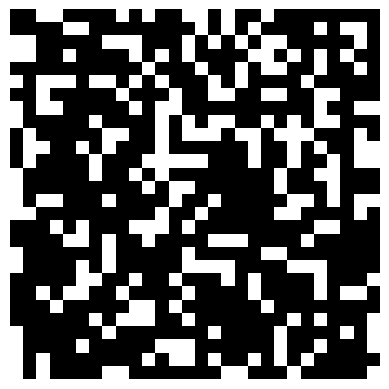

In [35]:
digit = 6
probs = proportions_x_ck_df.loc[6].values.reshape(28, 28)  # Redimensionar el array
probs_normalized = probs / np.max(probs)
synthetic_image = np.random.rand(28, 28) < probs_normalized  # Comparar el array redimensionado

plt.imshow(synthetic_image, cmap='gray')
plt.axis('off')
plt.show()

In [39]:
probs = np.array(probs, dtype=np.float64)
probs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0